Material informatics is a rapidly growing field, enabled by the simultaneous growth of high-performance computing and the availability of analystics software packages. The fields of materials discovery and design, hitherto belonging to the larger field of material science are now increasingly being aided by informatics techniques.

Target identification is typically the first phase of materials discovery and design. Typically, this involves a material or a set of material attributes for which a substitute needs to be found. There can be many reasons for why such a substitution is sought - to enable a cheaper product at similar or better performance, for instance. Another reason could be to improve product performance at comparable or cheaper cost.

Traditionally, the process of materials discovery and design has proceeded intuitively, based on extensive knowledge of materials gathered experimentally over the course of a few centuries. The process typically proceeds via experimental trial-and-error and it is estimated that the typical time taken to develop a new material is 20 years. The field of Material informatics aims to achieve a significant reduction in the time required to discover and develop new materials using a synthesis of experimental, computational and analytical techniques.

A number of new software packages tailored towards the broad aims of Materials Informatics have been developed in recent years. In this blog post, I will highlight two such packages - PyMatGen and MatMiner. PyMatGen is a Python based API that enables access to the Materials Project. MatMiner is a Python package that was written to convert materials information from databases such as the Materials Project to a format suitable for machine learning.

My objective in this blog post is to provide a rather straightforward example of materials discovery on the basis of the average valence electronic structure of materials. I first attempt to explain the concept of average electronic structure and its relevance to material discovery. I then outline specific questions that I attempt to answer by performing an unsupervised learning of the average electronic structure of materials in the database. Each subsequent section provides answers in the form of visualizations and tables. The last section provides key take-home messages from the analysis and some suggestions for expanding and improving upon the analysis in this post. Accompanying code for this post can be found at my repository on GitHub. 

Electronic structure:

Average electronic structure:

Questions  
1) When materials are represented on the basis of their average electronic structure, what is the optimum number of clusters that they can be grouped into?  
2) What materials are represented by cluster centers? Alternately, what unary material/materials are closest to cluster centers?   
3) Does the grouping make intuitive sense - i.e. are the cluster centers sufficiently far away from each other on the basis of chemical intuition?  
4) Given a target material, say Copper, what is the material (unary, binary and ternary respectively) whose electronic structure most closely resembles that of Copper?  
5) Given a target material, say Cobalt, what is the (binary and ternary) nitride material whose electronic structure most closely resembles that of Cobalt?  


# Question 1  

### When materials are represented on the basis of their average electronic structure, what is the optimum number of clusters that they can be grouped into? 

In [377]:
#import relevant packages
import numpy as np
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
from matminer.featurizers.composition import ValenceOrbital 
from matminer.featurizers.conversions import StructureToComposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances,pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

We first define an MPRester object that can be used to query the Materials Project.

In [378]:
#define a MPRester object
mpr = mg.MPRester(api_key='zUTBDkOXNL4RpPaQ')

Next, we create a function to fetch data from the Materials Project based on the number of elements in the material. These materials are respectively called 'unary', 'binary' and 'ternary'.

In [379]:
unary_list = mpr.get_data('*') # returns all data corresponding to mono-atomic materials in a list of dicts
unary = pd.DataFrame(unary_list)

In [380]:
binary_list = mpr.get_data('*-*') # returns all data corresponding to di-atomic materials in a list of dicts
binary = pd.DataFrame(binary_list)

For Ternary materials, the amount of data returned by the simple query ("*-*-*") is large enough that Materials Project automatically limits this transfer. To work around this limitation, we convert the problem of querying all ternary materials to a problem of querying ternary materials tagged by specific elements. This approach results in duplication of data, which can be taken care of in subsequent steps. In doing so, radioactive atoms and highly reactive (H, O, F, Cl, Br, I) or noble gases (He, Xe) were omitted from this list.

In [381]:
elem_list = ['Ag' ,'Al', 'As', 'Au', 'B', 'Be', 'Bi', 'C', 'Ca', 'Cd','Co','Cr','Cu','Fe','Ga','Ge',
             'Hf','Hg','In','Ir','K','La','Li','Mg','Mn','Mo','N','Na','Nb','Ni','Os','P','Pb','Pd',
             'Pt','Rh','Ru','S','Sb','Sc','Se','Si','Sn','Ta', 'Te','Ti','V','W','Y','Zn','Zr']

In [ ]:
ternary = pd.DataFrame()
for elem in elem_list:
    query = '*-*-'+elem #break-up query element-wise
    try:
        ternary_list = mpr.get_data(query)
        ternary = ternary.append(pd.DataFrame(ternary_list),ignore_index=True,verify_integrity=True)
    except Exception as e:
        print('Element for which we are getting this error -- {}'.format(elem))
        print(e)
        continue

Next we can filter out all materials that don't exist in the list of elements we used to create the ternary dataset.

In [538]:
unary = unary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in unary['elements'].tolist()]].copy()
binary = binary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in binary['elements'].tolist()]].copy()
ternary = ternary[[True if(set(cand_list).issubset(elem_list)) else False for cand_list in ternary['elements'].tolist()]].copy()

Next, the unary, binary and ternary databases are combined into a single dataset. Duplicates are removed.

In [595]:
materials_db = unary
materials_db = materials_db.append(binary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.append(ternary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.drop_duplicates(subset=['material_id'])

Check the number of unique materials in this dataset.

In [596]:
materials_db.shape[0]

25272

The next step is to create a PyMatGen "Composition" object (http://pymatgen.org/_modules/pymatgen/core/composition.html) for each unique material in the dataset. This step is a precursor to adding electronic structure related features to the dataset.

In [597]:
materials_db['composition'] = materials_db['pretty_formula'].apply(lambda x: mg.Composition(x))

The valence electronic structure of each material can be obtained from the ValenceOrbital Featurizer in MatMiner (https://hackingmaterials.github.io/matminer/matminer.featurizers.html#matminer.featurizers.composition.ValenceOrbital)
I am primarily interested in the 's', 'p' and 'd' orbital valence configuration

In [598]:
vo = ValenceOrbital(orbitals=['s','p','d'],props=['avg'])
materials_db = vo.featurize_dataframe(df=materials_db,col_id='composition')

To examine the output of this step it is useful to check the names of the columns that result from the featurizing operation

In [542]:
materials_db.columns

Index(['band_gap', 'cif', 'density', 'diel', 'e_above_hull', 'elasticity',
       'elements', 'energy', 'energy_per_atom', 'formation_energy_per_atom',
       'full_formula', 'hubbards', 'icsd_id', 'icsd_ids', 'is_compatible',
       'is_hubbard', 'material_id', 'nelements', 'nsites', 'oxide_type',
       'piezo', 'pretty_formula', 'spacegroup', 'tags', 'task_ids',
       'total_magnetization', 'unit_cell_formula', 'volume', 'composition',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons'],
      dtype='object')

In [543]:
Cu_coordinates = materials_db[materials_db['material_id']=='mp-30'][valence_columns]
Cu_coordinates

,avg s valence electrons,avg p valence electrons,avg d valence electrons
137,1.0,0.0,10.0


In [544]:
Ag_coordinates = materials_db[materials_db['material_id']=='mp-124'][valence_columns]
Ag_coordinates

,avg s valence electrons,avg p valence electrons,avg d valence electrons
2,1.0,0.0,10.0


For simplicity, it is useful to separate out the relevant features into a separate dataset and check for null values if any

In [600]:
valence_columns = ['avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons']
materials_valence = materials_db[valence_columns].copy()

In [601]:
null_values = materials_valence.isnull().sum()
print(null_values)

avg s valence electrons    0
avg p valence electrons    0
avg d valence electrons    0
dtype: int64


Since there are no null values, we can continue analysis on this dataset unimpeded.

Prior to clustering, it is useful to scale the datset to ensure that no feature dominates the distance calculation

In [602]:
scaler = StandardScaler()
mat_val_scaled = scaler.fit_transform(materials_valence)

In [603]:
materials_db['avg s valence electrons'] = mat_val_scaled[:,0]
materials_db['avg p valence electrons'] = mat_val_scaled[:,1]
materials_db['avg d valence electrons'] = mat_val_scaled[:,2]

We are now in a position to perform clustering on the dataset. A simple KMeans clustering can be performed to begin with.
To determine the optimum number of clusters, we can use the Elbow Technique (). In SciKit-Learn we can plot the inertia of the clustering operation (The sum of the squared distance of each point from the closest cluster) versus the number of clusters and see if an elbow exists. If it does, we can use the elbow point to determine the optimum number of clusters. If it doesn't we may need more anaysis.

In [604]:
num_clusters  = list(range(2,20))
inertia = []
for clusters in num_clusters:
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(mat_val_scaled)
    inertia.append(kmeans.inertia_)

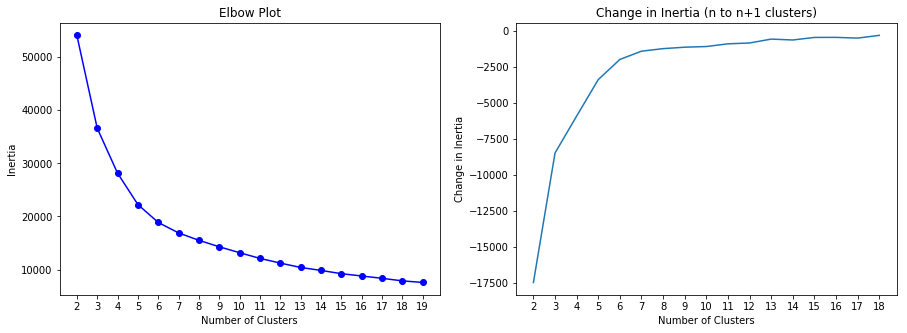

In [605]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(num_clusters,inertia,'bo-')
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.subplot(1,2,2)
plt.plot(num_clusters[:len(num_clusters)-1],np.diff(inertia))
plt.xticks(num_clusters[:len(num_clusters)-1])
plt.xlabel('Number of Clusters')
plt.ylabel('Change in Inertia')
plt.title('Change in Inertia (n to n+1 clusters)')
plt.show()

It is difficult to visually determine if a distinct elbow exists in the inertia plot on the left. It is therefore useful to plot the rate of change of inertia when the number of clusters is increased. This plot shows a distinct 'knee' (continuing with anatomical metaphors) between n=4 and n=6. 

This provides a tentative answer to question 1 - It appears that the dataset based on average electronic structure can be partitioned into 4-6 distinct clusters. 

# Questions 2 and 3

### What materials are represented by cluster centers? Alternately, what material/materials are closest to cluster centers? Does the grouping make intuitive sense - i.e. are the cluster centers sufficiently far away from each other on the basis of chemical intuition? 

In order to answer this question, we need to first determine what the cluster centers are for the optimum number of clusters (n=4 through 6)

In [694]:
kmeans = KMeans(n_clusters=4,random_state=1)
kmeans.fit(mat_val_scaled)
cluster_centers = kmeans.cluster_centers_

We now need a way to compare the distance of each material in the (scaled) dataset to each cluster center. Once we have this measure, we can find which material or group of materials most closely resembles the center. We can then choose this material to be (roughly) representative of its respective cluster.

The Scikit-Learn package provides such a method - pairwise_distances. Each Vector in matrix X is compared to each vector in matrix Y and a vector corresponding to the pairwise distances is returned for each Vector in Y.

In [607]:
distances = pairwise_distances(X=mat_val_scaled,Y=cluster_centers,metric='euclidean')

distances_to_centroid_1 = distances[:,0]
distances_to_centroid_2 = distances[:,1]
distances_to_centroid_3 = distances[:,2]
distances_to_centroid_4 = distances[:,3]

We can now assign these distances as columns to the original dataset and make use of the sorting functions that pandas provides in order to find the materials closest to cluster centers and print them out. In order to aid chemical intuition, we can also check which elemental materials are closest to the cluster centers. Since the properties of elemental solids are generally more familiar to people - Cu is a noble-metal, Si is a semiconductor, Na is an alkali metal for instance - it makes the comparison more accessible.

In [691]:
materials_db['distance_1'] = distances_to_centroid_1
materials_db['distance_2'] = distances_to_centroid_2
materials_db['distance_3'] = distances_to_centroid_3
materials_db['distance_4'] = distances_to_centroid_4

In [686]:
materials_db.sort_values(by=['distance_1'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_1']].head(1)

,material_id,pretty_formula,distance_1
9199,mp-680085,ZnS,0.088804


ZnS is (one, among many) of the materials closest to the centroid of cluster 1. 

In [692]:
materials_db.sort_values(by=['nelements','distance_1'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_1']].head(1)

,material_id,pretty_formula,distance_1
393,mp-109,Si,0.618399


Ruthenium (Ru) is the unary material/elemental material/mono-atomic material closest to cluster 1. It should be noted that the distance of Ru from the center of cluster 1 is an order of magnitude larger than that of the closest material, which is CrGaSe$_3$.

In [489]:
materials_db.sort_values(by=['distance_2'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_2']].head(1)

,material_id,pretty_formula,distance_2
29282,mp-777019,Li8SbS6,0.184025


Li$_8$SbS$_6$ is one of the materials closest to center of cluster 2.

In [693]:
materials_db.sort_values(by=['nelements','distance_2'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_2']].head(1)

,material_id,pretty_formula,distance_2
219,mp-1199937,K,0.785192


Carbon (C) is one of the elemental materials closest to center of cluster 2. As is the case for Ru, the distance of C from cluster center is significantly higher than that of the closest material Li$_8$SbS$_6$

In [491]:
materials_db.sort_values(by=['distance_3'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_3']].head(1)

,material_id,pretty_formula,distance_3
41967,mp-1183042,ZrSiRu2,0.157462


ZrSiRu$_2$ is one of the materials closest to center of cluster 3

In [695]:
materials_db.sort_values(by=['nelements','distance_3'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_3']].head(1)

,material_id,pretty_formula,distance_3
343,mp-10869,S,0.425981


Mercury (Hg) is one of the closest elemental materials to center of cluster 3. Hg is also closer to the center of the cluster than Ru and B are to their respective centers.

In [492]:
materials_db.sort_values(by=['distance_4'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_4']].head(1)

,material_id,pretty_formula,distance_4
6697,mp-1074458,Mg4Si3,0.103644


Mg$_4$Si$_3$ is one of the materials closest to the center of cluster 4

In [696]:
materials_db.sort_values(by=['nelements','distance_4'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_4']].head(1)

,material_id,pretty_formula,distance_4
124,mp-89,Cr,1.111057


Boron (B) is one of the elemental materials closest to center of cluster 4. Like Ru and C above, B is an order of magnitude farther from the closest material to its own cluster center. We will visualize this difference in the cells below. Intuitively, we should expect Hg to be significantly closer to its own cluster center than the other three materials.

So we have Ruthenium (Ru), Carbon (C), Mercury (Hg) and Boron (B) as the mono-atomic/unary materials closest to cluster centers. It's also useful to have a visual representation of this fact. Examining the periodic table it can be seen that Ru, and Hg are far apart from each other and from B and C, which are adjacent to each other.

![image.png](attachment:image.png)

In order to get a visual representation of the clusters and the respective closest elemental materials we can project the 3 dimensional feature space two dimensions at a time

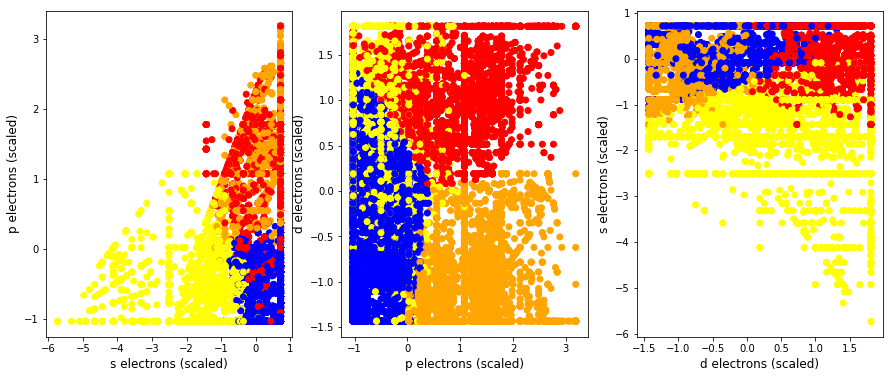

In [592]:
cluster_labels = kmeans.labels_
color_dict = {0:'orange',1:'red',2:'blue',3:'yellow'}

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(mat_val_scaled[:,0],mat_val_scaled[:,1],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('s electrons (scaled)',fontsize=12)
plt.ylabel('p electrons (scaled)',fontsize=12)
plt.subplot(1,3,2)
plt.scatter(mat_val_scaled[:,1],mat_val_scaled[:,2],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('p electrons (scaled)',fontsize=12)
plt.ylabel('d electrons (scaled)',fontsize=12)
plt.subplot(1,3,3)
plt.scatter(mat_val_scaled[:,2],mat_val_scaled[:,0],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('d electrons (scaled)',fontsize=12)
plt.ylabel('s electrons (scaled)',fontsize=12)
plt.show()                

Alternately we could project the 3 feature dimensions to two dimensions using PCA and then visualize the clusters. To compare visually the position of the above four elements (Ru, B, C, Hg) we will need to obtain the scaled coordinates of these points. We can then transform these coordinates to two dimensions using PCA and plot them on the same graph.

In [697]:
#Create a PCA object and fit and transform scaled feature matrix
pca = PCA(n_components=2)
two_d_mat_val_db = pca.fit_transform(mat_val_scaled)

#Append projected features to materials database
materials_db['proj_dim_1'] = two_d_mat_val_db[:,0]
materials_db['proj_dim_2'] = two_d_mat_val_db[:,1]

# Ru closest to cluster 1 has material id mp-8639
projected_Ru_coordinates = materials_db[materials_db['material_id']=='mp-109']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# C closest to cluster 2 has material id mp-568410
projected_C_coordinates = materials_db[materials_db['material_id']=='mp-1199937']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# Hg closest to cluster 3 has material id mp-1077098
projected_Hg_coordinates = materials_db[materials_db['material_id']=='mp-10869']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# B closest to cluster 4 has material id mp-1228790
projected_B_coordinates = materials_db[materials_db['material_id']=='mp-89']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

It is also useful to plot the cluster centers for reference

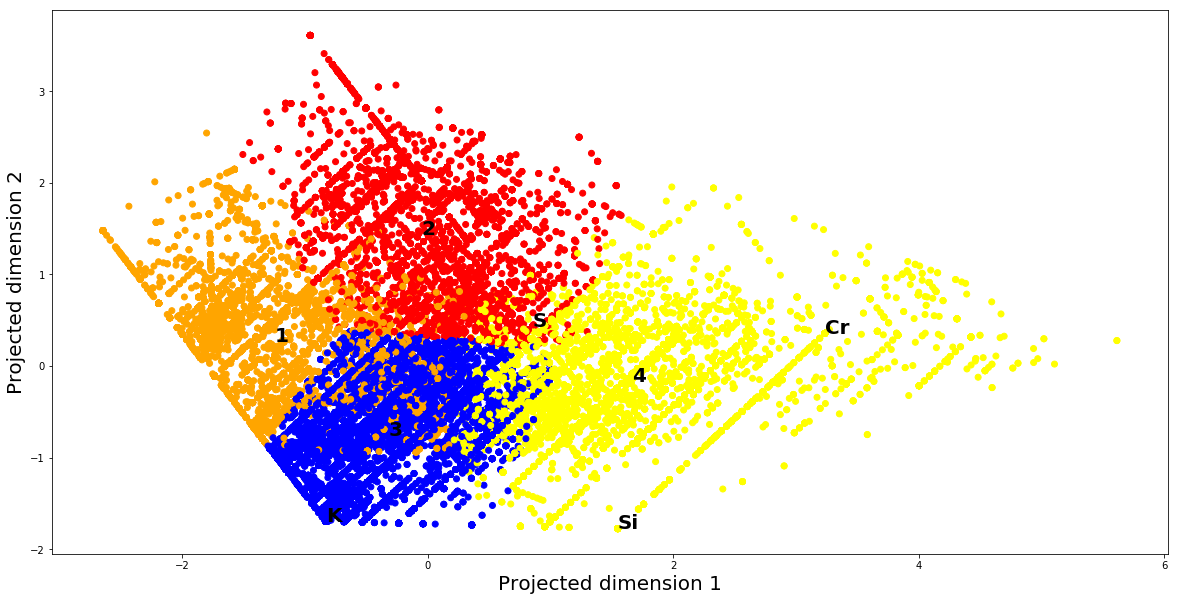

In [699]:
cluster_centers = kmeans.cluster_centers_
cluster_centers_pca = pca.transform(cluster_centers) #transform cluster center coordinates to projected dimensions

plt.figure(figsize=(20,10))
plt.scatter(two_d_mat_val_db[:,0],two_d_mat_val_db[:,1],color=[color_dict[label] for label in cluster_labels])

# Plot Ru coordinates in black
plt.text(projected_Ru_coordinates[0],projected_Ru_coordinates[1],'Si',color='black',fontsize=20,weight="bold")

# Plot C coordinates in black
plt.text(projected_C_coordinates[0],projected_C_coordinates[1],'K',color='black',fontsize=20,weight="bold")
         
# Plot Hg coordinates in black
plt.text(projected_Hg_coordinates[0],projected_Hg_coordinates[1],'S',color='black',fontsize=20,weight="bold")
         
# Plot B coordinates in black
plt.text(projected_B_coordinates[0],projected_B_coordinates[1],'Cr',color='black',fontsize=20,weight="bold")

plt.xlabel('Projected dimension 1',fontsize=20)
plt.ylabel('Projected dimension 2',fontsize=20)


for cluster_count,cluster_center in enumerate(cluster_centers_pca):
    plt.text(cluster_center[0],cluster_center[1],str(cluster_count+1),color='black',fontsize=20,weight="bold")
    
plt.show()

On the basis of the analysis above, we are now in a position to answer questions 2 and 3. CrGaSe$_3$, Li$_8$SbS$_6$, ZrSiRu$_2$ and Mg$_4$Si$_3$ are representative of cluster centroids. Ru, C, Hg and B are elemental materials closest to cluster centers. CrGaSe$_3$ is a ferromagnetic semiconductor (https://pubs.rsc.org/en/content/articlelanding/2018/cp/c7cp07912e#!divAbstract) with a tendency to form mono-atomic layers (like graphene, which is a form of carbon with a single atomic layer of carbon atoms arranged in a honeycomb shape). Li$_8$SbS$_6$ seems to be a semi-conducting ferromagnetic material https://materialsproject.org/materials/mp-777019/. ZrSiRu$_2$ is a non-magnetic semiconductor (https://www.materialsproject.org/materials/mp-1183042/) and Mg$_4$Si$_3$ is a non-magnetic metal (https://www.materialsproject.org/materials/mp-1074458/). In terms of elemental material properties, Ru is a metal, C is a semiconductor, Hg is a liquid metal and B is a metalloid.

It is safe to say that the results returned by the clustering analysis show some differentiation in terms of metallic properties. It is equally fair to point out that the differentiation is not satisfactory enough - the materials representative of their clusters show some similarity in terms of properties. This is to be expected, to some degree, since the features used are rather elementary. A more detailed set of features, both structural and electronic, would be needed to separate materials more cleanly.

# Question 4

### Given a target material, say Copper, what is the material (unary, binary and ternary respectively) whose electronic structure most closely resembles that of Copper?  

To answer this question, we first find the material-id corresponding to ground state copper (mp-30). Using this material id, we can extract the scaled coordinates of copper. 

In [561]:
Cu_coordinates = materials_db[materials_db['material_id']=='mp-30'][valence_columns]
Cu_coordinates

,avg s valence electrons,avg p valence electrons,avg d valence electrons
137,-2.508945,-1.027103,1.8113


In [562]:
Ag_coordinates = materials_db[materials_db['material_id']=='mp-124'][valence_columns]

In [563]:
Ag_coordinates

,avg s valence electrons,avg p valence electrons,avg d valence electrons
2,-2.508945,-1.027103,1.8113


In [564]:
distances_to_Cu = pairwise_distances(Y=Cu_coordinates,X=materials_db[valence_columns],metric='euclidean')

In [565]:
materials_db['distances_to_Cu'] = distances_to_Cu

In [577]:
materials_db.sort_values(by=['distances_to_Cu'],ascending=True,axis=0,inplace=True)

In [580]:
materials_db[['material_id','nsites','pretty_formula','distances_to_Cu']].head(100)

,material_id,nsites,pretty_formula,distances_to_Cu
0,mp-8566,4,Ag,0.000000
133,mp-1010136,1,Cu,0.000000
132,mp-989782,2,Cu,0.000000
9866,mp-1093618,4,Cu2AgAu,0.000000
513,mp-1184011,4,Cu3Ag,0.000000
1417,mp-2258,4,Cu3Au,0.000000
1420,mp-1225761,5,Cu4Au,0.000000
512,mp-984351,8,CuAg3,0.000000
1414,mp-1225677,2,CuAu,0.000000
1415,mp-522,2,CuAu,0.000000


The elemental solids closest to Copper are Silver and Gold respectively, which matches chemical intuition perfectly.
In fact, this result is guaranteed by the fact that we use average valence electronic structure for our features. Since Ag and Silver have the same valence electronic structure (they belong to the same column on the periodic table) it is therefore to be expected that they are close neighbors in this scheme.  

While several binary metals are close to Cu, following the reasoning from the previous paragraph it is perhaps obvious that alloys of Ag, Au and Cu will have an identical electronic structure.

The ternary material closest to Cu, unsurprisingly is also an alloy of Cu, Ag and Au together. The unexpected results are those of HgPd and ZnPd - an alloy of Mercury and Zinc respectively with Palladium. The electronic structure of these materials is dissimilar to Copper. In a limited sense, it can thus be said we have performed materials discovery using computational tools!

# 5) Question 5

### Given a target material, say Cobalt, what is the (binary and ternary) nitride material whose electronic structure most closely resembles that of Cobalt? 

Similar to the previous question, we first get the coordinates of the ground state of Cobalt.

In [700]:
Co_coordinates = materials_db[materials_db['material_id']=='mp-54'][valence_columns]
Co_coordinates

,avg s valence electrons,avg p valence electrons,avg d valence electrons
121,0.714318,-1.027103,0.838502


We then filter out those materials that don't contain N atoms in them

In [710]:
N_materials = materials_db[['N' in element_list for element_list in materials_db['elements'].tolist()]].copy()

In [711]:
distance_nitrides_to_Co = pairwise_distances(X=N_materials[valence_columns],Y=Co_coordinates,metric='euclidean')

In [712]:
N_materials['distance_nitrides_to_Co'] = distance_nitrides_to_Co

In [713]:
N_materials.sort_values(by='distance_nitrides_to_Co',inplace=True,axis=0,ascending=True)

In [714]:
N_materials[['material_id','nsites','pretty_formula','distance_nitrides_to_Co']].head(20)

,material_id,nsites,pretty_formula,distance_nitrides_to_Co
24351,mp-1016107,26,Hf6Zn6N,0.532693
17056,mp-1017554,5,CdNi3N,0.635683
34748,mp-1069270,5,ZnNi3N,0.635683
4060,mp-555,9,Fe8N,0.644594
7719,mp-1094090,5,Ni4N,0.661620
7717,mp-20839,5,Ni4N,0.661620
24790,mp-1193322,29,Mg(Hg11N3)2,0.681230
24789,mp-1180534,29,Mg(Hg11N3)2,0.681230
16719,mp-1017553,5,CdCo3N,0.683507
13371,mp-1097708,77,Fe65(BN)6,0.708265
